In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

import myLib_barChart as myBar
import myLib_confMatrix as myMatrix
import myLib_parseData as myParse
import myLib_pieChart as myPie
import myLib_table as myTable
import myLib_testModel as myTest
from myLib_testModel import lettToSoft
import myLib_writeFile as myWrite

# LOAD DATASET AND PREPARE TRAIN - TEST

In this section the functions loadDataFromTxt and parseTrainTest are called. These allow to load the dataset from the txt files into matrices and then separate them in smaller matrices for testing and training. 

In [2]:
vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_OL')
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)

******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (103600, 5)
Tot samples      -> 518


*** Separate train-valid

Train data shape  -> (361, 600)
Test data shape   -> (155, 600)


In [3]:
B_data, B_label = myParse.loadDataFromTxt('B_dataset')
B_train_data, B_train_label, B_test_data, B_test_label = myParse.parseTrainTest(B_data, B_label, 0.7)

******* Dataset for letter ['B']

Raw shape        -> (39400, 5)
Tot samples      -> 197


*** Separate train-valid

Train data shape  -> (136, 600)
Test data shape   -> (59, 600)


In [4]:
M_data, M_label = myParse.loadDataFromTxt('M_dataset')
M_train_data, M_train_label, M_test_data, M_test_label = myParse.parseTrainTest(M_data, M_label, 0.7)

******* Dataset for letter ['M']

Raw shape        -> (39000, 5)
Tot samples      -> 195


*** Separate train-valid

Train data shape  -> (135, 600)
Test data shape   -> (58, 600)


In [5]:
R_data, R_label = myParse.loadDataFromTxt('R_dataset')
R_train_data, R_train_label, R_test_data, R_test_label = myParse.parseTrainTest(R_data, R_label, 0.7)

******* Dataset for letter ['R']

Raw shape        -> (39000, 5)
Tot samples      -> 195


*** Separate train-valid

Train data shape  -> (135, 600)
Test data shape   -> (58, 600)


###  Create a dataset of all letters

In this smaller section all the previous matrices are stacked together and then shuffled in order to create two big matrices that contain all the letters. These two matrices reppresent the entire dataset for training and testing the OL methods.

In [6]:
# Create a matrix that contains all the train data
data_all = OL_data_train_vow
data_all = np.vstack(( data_all, B_train_data))
data_all = np.vstack(( data_all, R_train_data))
data_all = np.vstack(( data_all, M_train_data))
# Create an array that contains all the train labels
label_all = OL_label_train_vow
label_all = np.hstack(( label_all, B_train_label))
label_all = np.hstack(( label_all, R_train_label))
label_all = np.hstack(( label_all, M_train_label))
# Shuffle the matrix and the label
data_all, label_all = myParse.shuffleDataset(data_all, label_all)

print('data_all has shape  ' + str(data_all.shape))
print('label_all has shape ' + str(label_all.shape))

data_all has shape  (767, 600)
label_all has shape (767,)


The class Data_Container is just a container that I created in order to have all the dataset in a single object. This is useful for the plotting functions because it allows me to give as input to the function just one object and not the entire list of datasets.

In [7]:
class Data_Container(object):
    def __init__(self):

        self.R_test_data       = R_test_data
        self.R_test_label      = R_test_label
        self.B_test_data       = B_test_data
        self.B_test_label      = B_test_label
        self.M_test_data       = M_test_data
        self.M_test_label      = M_test_label
        self.R_test_data       = R_test_data
        self.OL_data_test_vow  = OL_data_test_vow
        self.OL_label_test_vow = OL_label_test_vow
        
OL_testing_data = Data_Container()

### Check the content of the dataset

This block is used only to check the type of letters that are inside the datasets that I imported. It's used in order to see if the datasets are created and saved correctly.

In [8]:
print('VOWELS DATASET SANITY CHECK')
myParse.sanityCheckDataset(vowels_label)
print('\nB DATASET SANITY CHECK')
myParse.sanityCheckDataset(B_label)
print('\nR DATASET SANITY CHECK')
myParse.sanityCheckDataset(R_label)
print('\nM DATASET SANITY CHECK')
myParse.sanityCheckDataset(M_label)
print('\nMIXED DATASET SANITY CHECK')
myParse.sanityCheckDataset(label_all)

VOWELS DATASET SANITY CHECK
    The letters found are:              ['O', 'U', 'A', 'E', 'I']
    And for each letter the counter is: [103. 103. 103. 103. 103.   1.   0.   0.   0.]

B DATASET SANITY CHECK
    The letters found are:              ['B']
    And for each letter the counter is: [194.   1.   0.   0.   0.   0.   0.   0.   0.]

R DATASET SANITY CHECK
    The letters found are:              ['R']
    And for each letter the counter is: [192.   1.   0.   0.   0.   0.   0.   0.   0.]

M DATASET SANITY CHECK
    The letters found are:              ['M']
    And for each letter the counter is: [192.   1.   0.   0.   0.   0.   0.   0.   0.]

MIXED DATASET SANITY CHECK
    The letters found are:              ['M', 'E', 'R', 'A', 'O', 'I', 'B', 'U']
    And for each letter the counter is: [134.  72. 135.  72.  73.  72. 136.  72.   1.]


#  ------------------------------------------------------------------------

# LOAD TF TRAINED MODEL

In this section I load the frozen model. The frozen model is the NN that has been trained with keras on the PC. The script that trains this model is called 'run_trainFroznModel.py'

In [9]:
MODEL_PATH = "C:/Users/massi/UNI/Magistrale/Anno 5/Semestre 2/Tesi/Code/Python/Saved_models/"

In [10]:
model = keras.models.load_model(MODEL_PATH + 'Original_model/model.h5')

#  ------------------------------------------------------------------------

# TINY OL

In this section the main part of the continual learning study is found. Here can be found the functions used for implementing the different algorithms. 

The function below is an implementation of the softmx function. I had to use this because I noticed that the sofmtax function used from keras and other methods for computing the sotmax operation gave different results.

In [11]:
def my_Softmax(array):
    
    if(len(array.shape)==2):
        array = array[0]
        
    size    = len(array)
    ret_ary = np.zeros([len(array)])
    m       = array[0]
    sum_val = 0

    for i in range(0, size):
        if(m<array[i]):
            m = array[i]

    for i in range(0, size):
        sum_val += np.exp(array[i] - m)

    constant = m + np.log(sum_val)
    for i in range(0, size):
        ret_ary[i] = np.exp(array[i] - constant);
        
    return ret_ary


## TinyOL class

This class is just a container for all the informations that are required in order to use correctly a tinyOL model. The idea is to createa  container in which everything is stored and then simply change the method for the training.

In [12]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
        self.label = ['A', 'E', 'I', 'O', 'U']                  # the origina model knows only the vowels
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm
        
        self.width = self.W.shape[0]        # shape of the weights matrix
        
        
        # Related to the results fo the model
        self.confusion_matrix = []          # container for the confusion matrix
        self.correct_ary = []               # array that contains the number of correct prediction for each letter
        self.mistake_ary = []               # array that contains the number of mistaken prediction for each letter
        self.totals_ary = []                # array that contains the number of total prediction for each letter
        
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.matmul(x, self.W) + self.b
        mat_prod = np.array(mat_prod)
        return  my_Softmax(mat_prod) #  #tf.nn.softmax(mat_prod)  #  

## TinyOL functions

This function is used in all methods before the feed forward of the OL layer. This function is required because it checks if the input letter is already known. If this is not true it will increse the dimension of the last layre (weight matrix and biases array) and also save the new letter in the 'known classes' array.

In [13]:
def checkNewClass(model, y_true, y_true_soft, i, gauss):
    """ Function that will check if the current letter is known to the model. If not increase layer dimension.
    
    This function checks if the letter that the model shoudl train on is an already known label. If this is not 
    true the function will increase the dimension of th weights matrix and the biases array.
    
    Parameters
    ----------
    model : class
        Container for the model weights, biases, parameters.
    
    y_true : array_like
        Array of correct labels
    
    y_true_soft : array_like
        Hot one encoded array of true labels
    
    i : int
        Position to check of the array y_true and y_true_soft
    
    gauss : int
        Value true/false that defines if the initialization of the new columns of the matrix should be with 
        a gaussian distribution.
    """
    
    # Check if letter is new
    found = 0
    for k in range(0, len(model.label)):
        if (y_true[i] == model.label[k]):
            found = 1

    # If first time seeing this letter
    if (found == 0):

        model.label.append(y_true[i])   # Add new letter to label
        print(f'\n\n    New letter detected -> letter \033[1m{y_true[i]}\033[0m \n')
    
        if(gauss==0):
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
        elif(gauss==1):
            gaussW = np.zeros([model.width,1])
            for i in range(0,model.width):
                gaussW[i,0] = random.gauss(0, 0.01)
            gaussB = random.gauss(0, 0.01)
            model.W = np.hstack((model.W, gaussW))
            model.b = np.hstack((model.b, gaussB))
        elif(gauss==2):  # sporcariaper far funzionare LWF
            model.W = np.hstack((model.W, np.zeros([model.width,1])))
            model.b = np.hstack((model.b, np.zeros([1])))
            
                   
        print(f'    Now W is -> {model.W.shape}              and b is -> {model.b.shape}\n\n')

        y_true_soft = lettToSoft(y_true, model.label)
                
    return y_true_soft

From here the functions that implement the different methods can be found. The explanation of the code od these function is not here but it can be found in the paper "Continuous learning in single incremental taskscenarios" and some schemes cna be found in my presentation.

### OL

In [14]:
def trainOneEpoch_OL(model, x, y_true):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        # PPREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])        
          
        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL MINI BATCH

In [15]:
def trainOneEpoch_OL_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    y_true_soft = lettToSoft(y_true, model.label)     # Transform the true label letters in softmax array
        
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        if(i%batch_size==0):
                model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
                model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]

                sum_gradW = np.zeros([h, 8])  #reset each batch  
                sum_gradB = np.zeros([1, 8])  #reset each batch   
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h): 
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:w] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:w] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W = model.W - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,:w]
            model.b = model.b - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [16]:
  def trainOneEpoch_OL_v2(model, x, y_true):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
            
    # Cycle over every sample
    for i in range(0, tot_samples):
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 1)    # Check if letter is new
        
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]
        cost[0] = 0
        cost[1] = 0
        cost[2] = 0
        cost[3] = 0

        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW[:]

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b[5:] = model.b[5:]-db[5:]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2 MINI BATCH

In [17]:
def trainOneEpoch_OL_v2_miniBatch(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    sum_gradW = np.zeros([model.W.shape[0], 8])
    sum_gradB = np.zeros([1, 8])
    
    # Transform the true label letters in softmax array
    y_true_soft = lettToSoft(y_true, model.label)
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # If beginning of batch
        if(i%batch_size==0):
                model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
                model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
                sum_gradW = np.zeros([h, 8])  # reset
                sum_gradB = np.zeros([1, 8])  # reset
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft[i,:]

        for j in range(0,h):  
            # Update weights
            tmp = np.multiply(cost, y_ML[0,j]) 
            deltaW = np.zeros([1,8])
            deltaW[0,:tmp.shape[0]] = tmp  
            sum_gradW[j,:] += deltaW[0,:]

        # Update biases
        deltaB = np.zeros([1,8])
        deltaB[0,:cost.shape[0]] = cost
        sum_gradB += deltaB

        # If last iteration
        if(i==tot_samples-1):
            model.W[:,5:] = model.W[:,5:] - np.multiply(sum_gradW, 1/batch_size*learn_rate)[:h,5:w]
            model.b[5:]   = model.b[5:]   - np.multiply(sum_gradB, 1/batch_size*learn_rate)[0,5:w]
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF

In [18]:
def trainOneEpochOL_LWF(model, x, y_true):
    
    print('**********************************\nPerforming training with LWF - STOCHASTIC\n ') 
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    y_LWF = np.zeros([1, 8])    # Define container for LWF

    # DEFINE ORIGINAL WEIGHTS AND BIASES
    LWF_w = model.W
    LWF_b = model.b
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 2)   # Check if letter is new
        
        w = model.W.shape[1]
        h = model.W.shape[0]
        
        # va da 1 a 0
        lam = 100/(100+cntr)    #1-i/493    #  1/(20+cntr)        #
             
        # PREDICTIONS
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])
        
        mat_prod = np.array(np.matmul(y_ML, LWF_w) + LWF_b)
        y_LWF[0,:5] = my_Softmax(mat_prod)   
          
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]

        for j in range(0,h):
            # Update weights
            deltaW_norm = np.multiply(cost_norm,1-lam)
            deltaW_LWF  = np.multiply(cost_LWF, lam)
            deltaW      = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j])
            dW          = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db_norm = np.multiply(cost_norm, 1-lam)
        db_LWF  = np.multiply(cost_LWF, lam)
        db      = np.multiply(db_norm+db_LWF, learn_rate)
        model.b = model.b-db
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF MINI BATCH

In [19]:
def trainOneEpochOL_LWF_v2(model, x, y_true, batch_size):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    
    y_true_soft = lettToSoft(y_true, model.label)  # Transform the true label letters in softmax array
        
    w = model.W.shape[1]
        
    LWF_w = np.zeros([model.W.shape[0], 8]) # alocate
    LWF_b = np.zeros([1, 8]) 
    y_LWF = np.zeros([1, 8])
    
    LWF_w[:,:w] = model.W   # copy from TF
    LWF_b[0,:w] = model.b
    
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0)   # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # END OF BATCH
        if(i%batch_size==0 and i!=0):            
            LWF_w[:,:w] = np.copy(model.W)    # update the LWF w matrix
            LWF_b[0,:w] = np.copy(model.b)    # update the LWF b matrix
                
        #lam = 1/(2+cntr)
        if(cntr<batch_size):
            lam = 1
        else:
            lam = batch_size/cntr  #(cntr/493)   va da 0 a 1
    
        # PREDICTION - Frozen + OL
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        y_pred = model.predict(y_ML[0,:])  
        
        mat_prod = np.array(np.matmul(y_ML, LWF_w[:,:w]) + LWF_b[0,:w])
        y_LWF[0,:w] = my_Softmax(mat_prod)        


         
        # ---- BACKPROPAGATION | MINI BATCH + LWF        
        cost_norm = y_pred-y_true_soft[i,:]
        cost_LWF  = y_pred-y_LWF[0,:w]
        
        lam_cost_norm = np.multiply(cost_norm, 1-lam)
        lam_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            deltaW = np.multiply(lam_cost_norm+lam_cost_LWF, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW          
            
        # Update biases 
        db = np.multiply(lam_cost_norm+lam_cost_LWF, learn_rate)
        model.b = model.b-db   
                        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [20]:
def trainOneEpoch_CWR(model, x, y_true, batch_size):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr=1
    learn_rate = model.l_rate
    tot_samples = x.shape[0]
    TW = np.zeros([model.W.shape[0], 8])
    TB = np.zeros([1, 8])
    found_lett = np.zeros([1,8])
    
    y_true_soft = lettToSoft(y_true, model.label)    # Transform the true label letters in softmax array
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        y_true_soft = checkNewClass(model, y_true, y_true_soft, i, 0) # Check if letter is new
        
        h = model.W.shape[0]
        w = model.W.shape[1]
                
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(0, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
                    
            TW[:h,:w]  = np.copy(model.W)
            TB[0,:w]   = np.copy(model.b)
            found_lett = np.zeros([1,8])  # reset
        elif(i==0):
            TW = np.zeros([h, 8])         # reset  
            TB = np.zeros([1, 8])         # reset  
            found_lett = np.zeros([1,8])  # reset
                
        found_lett[0,np.argmax(y_true_soft[i,:])] += 1  # update the letter counter
            
        # PREDICTION
        y_ML = model.ML_frozen.predict(x[i,:].reshape(1,x.shape[1]))
        mat_prod = np.array(np.matmul(y_ML, TW) + TB)
        y_pred = my_Softmax(mat_prod)        


        # BACKPROPAGATION
        cost = y_pred[:w]-y_true_soft[i,:]

        # Update weights
        for j in range(0,h):
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            TW[j,:w] = TW[j,:w] - dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        TB[0,:w] = TB[0,:w]-db

        # If last iteration
        if(i==tot_samples-1):
            for k in range(5, w):
                if(found_lett[0,k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[0,k])
                    tempB = np.multiply(model.b[k]  , found_lett[0,k])
                    model.W[:,k] = np.multiply(tempW+TW[:,k], 1/(found_lett[0,k]+1))
                    model.b[k]   = np.multiply(tempB+TB[0,k], 1/(found_lett[0,k]+1))
        
        print(f"\r    Currently at {np.round(np.round(cntr/x.shape[0],4)*100,2)}% of dataset", end="")
        cntr +=1
        

# Trainings

Now let's dfine some important values for the training and then actually train each single OL layer witha  different method. The 0 and 1 below are used in order to activate or deactivate the training and the following plots of a specific method.

In [21]:
batch_size_OL = 8

In [22]:
# DEFINE WHICH TRAINING AND PLOTS TO SHOW

KERAS      = 1
OL_vowels  = 1
OL         = 1
OL_mini    = 1
LWF        = 1
LWF_mini   = 1
OL_v2      = 1
OL_v2_mini = 1
CWR        = 1

### Define KERAS model

In [23]:
if(KERAS==1):
    Model_KERAS = Custom_Layer(model)
    Model_KERAS.title = 'KERAS'
    Model_KERAS.filename = 'KERAS'
    Model_KERAS.label = ['A','E','I','O','U','B','R','M']
    # DO NOT PERFORM TRAINING, KEEP IT AS IT IS, IT'S THE ORIGINAL MODEL

### Train with OL only on vowels (just create the class, actually don't train)

In [24]:
if(OL_vowels==1):
    Model_OL_vowels = Custom_Layer(model)
    Model_OL_vowels.title = 'VOWELS'
    Model_OL_vowels.filename = 'OL_vowels'
    Model_OL_vowels.l_rate = 0.000005
    
    trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_label_train_vow)

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 100.0% of dataset

### Train with OL method

In [25]:
if(OL==1):
    Model_OL_all_mixed = Custom_Layer(model)
    Model_OL_all_mixed.title = 'OL' 
    Model_OL_all_mixed.filename = 'OL'
    Model_OL_all_mixed.l_rate = 0.000005

    trainOneEpoch_OL(Model_OL_all_mixed, data_all, label_all)

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL + mini batch

In [26]:
if(OL_mini==1):
    Model_OL_mini = Custom_Layer(model)
    Model_OL_mini.title = 'OL + mini batch'
    Model_OL_mini.filename = 'OL_batches'
    Model_OL_mini.l_rate = 0.0001

    trainOneEpoch_OL_miniBatch(Model_OL_mini, data_all, label_all, batch_size_OL)

**********************************
Performing training with OL METHOD - MINI BATCH

    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with LWF

In [27]:
if(LWF==1):
    Model_LWF_1 = Custom_Layer(model)
    Model_LWF_1.title = 'LWF'
    Model_LWF_1.filename = 'LWF'   
    Model_LWF_1.l_rate = 0.01 #0.0001

    trainOneEpochOL_LWF(Model_LWF_1, data_all, label_all)   

**********************************
Performing training with LWF - STOCHASTIC
 
    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train LWF + mini batches

In [28]:
if(LWF_mini==1):
    Model_LWF_2 = Custom_Layer(model)
    Model_LWF_2.title = 'LWF + mini batch'
    Model_LWF_2.filename = 'LWF_batches'
    Model_LWF_2.l_rate = 0.000001

    trainOneEpochOL_LWF_v2(Model_LWF_2, data_all, label_all, batch_size_OL)

**********************************
Performing training with LWF - MINI BATCH

    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 

In [45]:
if(OL_v2==1):
    Model_OL_v2 = Custom_Layer(model)
    Model_OL_v2.title = 'OL v2' 
    Model_OL_v2.filename = 'OL_v2'
    Model_OL_v2.l_rate = 0.00005

    trainOneEpoch_OL_v2(Model_OL_v2, data_all, label_all)

**********************************
Performing training with CWR METHOD - STOCASTICH 

    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with OL v2 + mini batch

In [30]:
if(OL_v2_mini==1):
    Model_OL_v2_miniBatch = Custom_Layer(model)
    Model_OL_v2_miniBatch.title = 'OL v2 + mini batch'
    Model_OL_v2_miniBatch.filename = 'OL_v2_batches'
    Model_OL_v2_miniBatch.l_rate = 0.001

    trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, data_all, label_all, batch_size_OL)

**********************************
Performing training with CWR - MINI BATCH 
 
    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

### Train with CWR

In [33]:
if(CWR==1):
    Model_CWR = Custom_Layer(model) 
    Model_CWR.title = 'CWR'
    Model_CWR.filename = 'CWR'
    Model_CWR.l_rate = 0.00005

    trainOneEpoch_CWR(Model_CWR, data_all, label_all, batch_size_OL)

**********************************
Performing training CWR 
 
    Currently at 0.13% of dataset

    New letter detected -> letter M 

    Now W is -> (128, 6)              and b is -> (6,)


    Currently at 2.22% of dataset

    New letter detected -> letter R 

    Now W is -> (128, 7)              and b is -> (7,)


    Currently at 2.61% of dataset

    New letter detected -> letter B 

    Now W is -> (128, 8)              and b is -> (8,)


    Currently at 100.0% of dataset

# SIMULATION PLOTS

### Original model

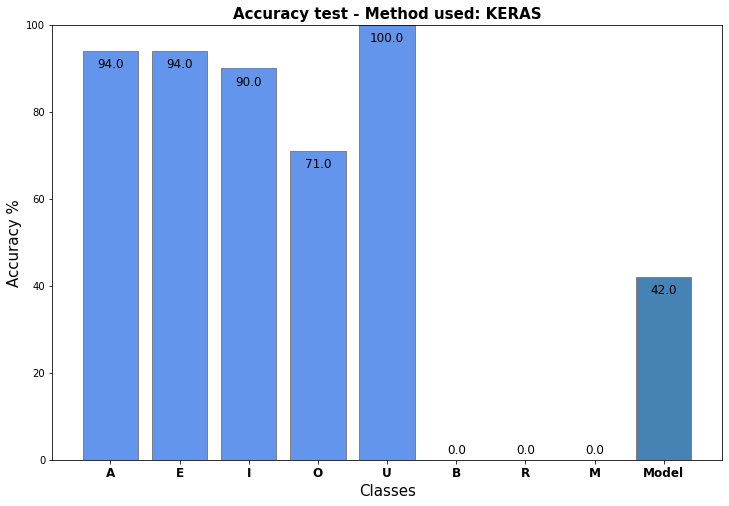

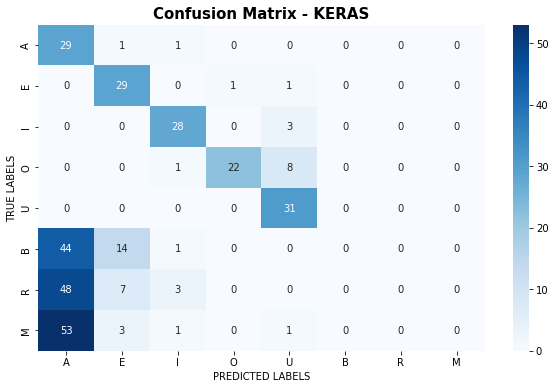

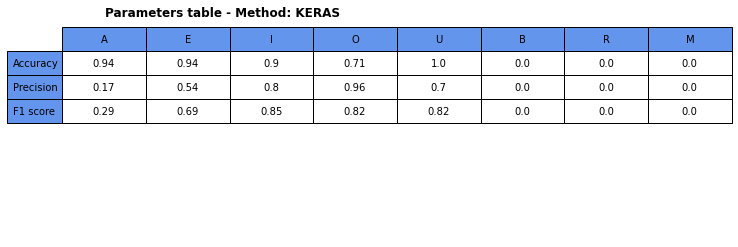

In [34]:
if(KERAS==1):
    myTest.test_OLlayer(Model_KERAS, OL_testing_data)
    myBar.plot_barChart(Model_KERAS)   
    myMatrix.plot_confMatrix(Model_KERAS)
    myTable.table_params(Model_KERAS)

### Only vowels

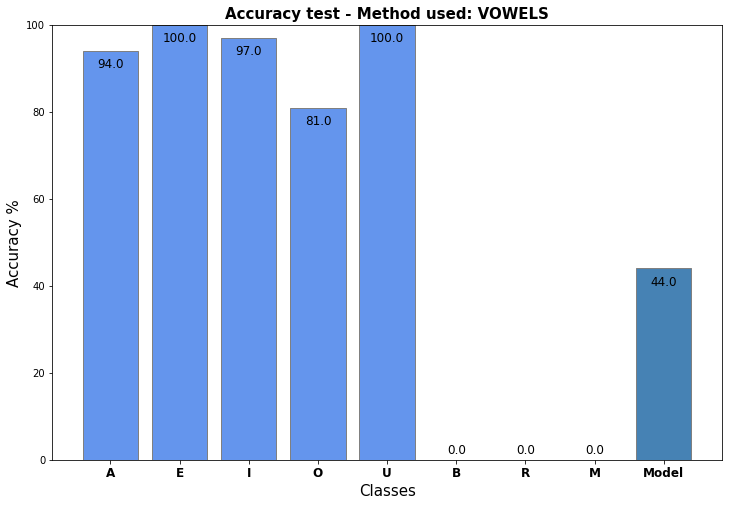

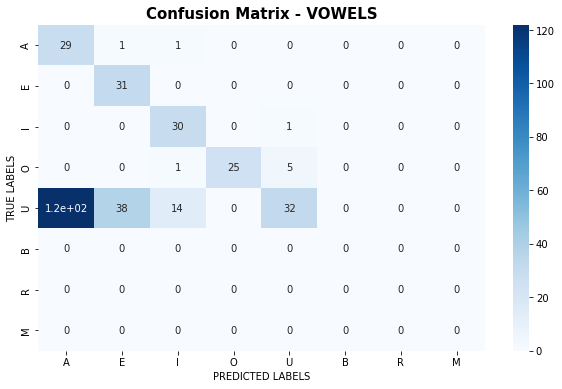

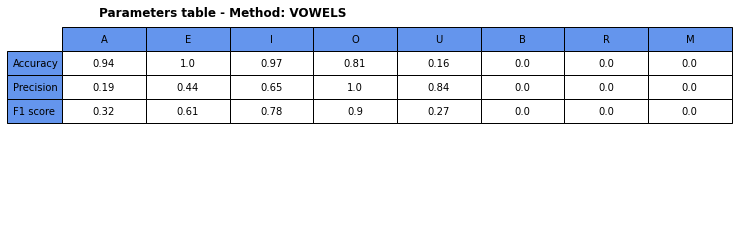

In [35]:
if(OL_vowels==1):
    myTest.test_OLlayer(Model_OL_vowels, OL_testing_data)
    myBar.plot_barChart(Model_OL_vowels)
    myMatrix.plot_confMatrix(Model_OL_vowels)
    myTable.table_params(Model_OL_vowels)

### OL

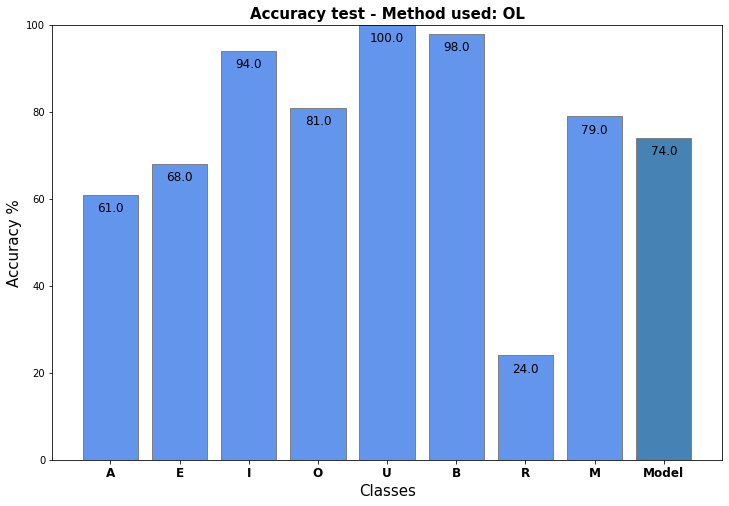

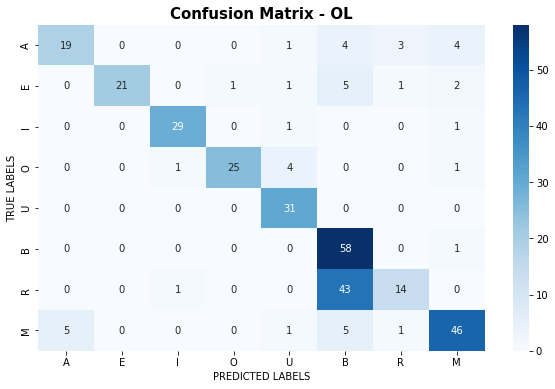

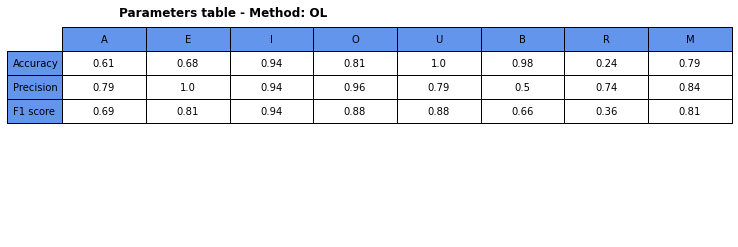

In [36]:
if(OL==1):
    myTest.test_OLlayer(Model_OL_all_mixed, OL_testing_data)
    myBar.plot_barChart(Model_OL_all_mixed)
    myMatrix.plot_confMatrix(Model_OL_all_mixed)
    myTable.table_params(Model_OL_all_mixed)

### OL + mini batch

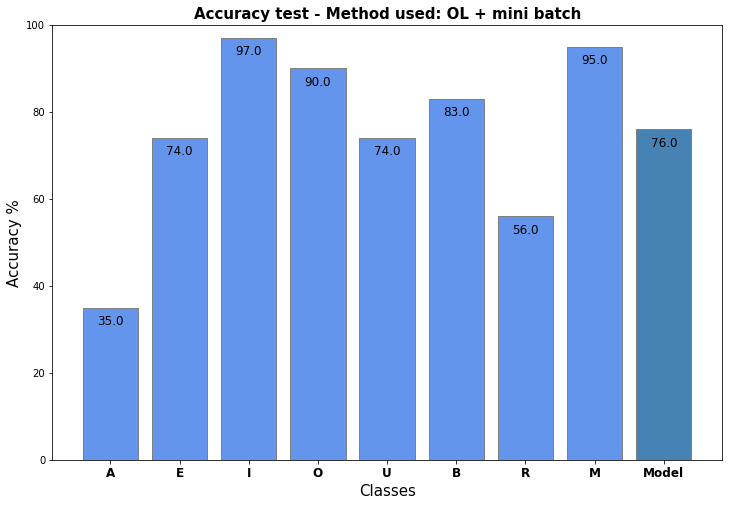

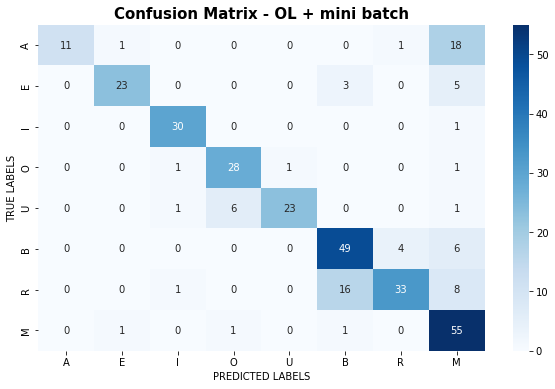

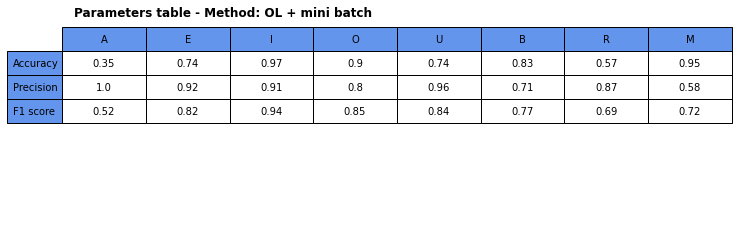

In [37]:
if(OL_mini==1):
    myTest.test_OLlayer(Model_OL_mini, OL_testing_data)
    myBar.plot_barChart(Model_OL_mini)
    myMatrix.plot_confMatrix(Model_OL_mini)
    myTable.table_params(Model_OL_mini)

### LWF

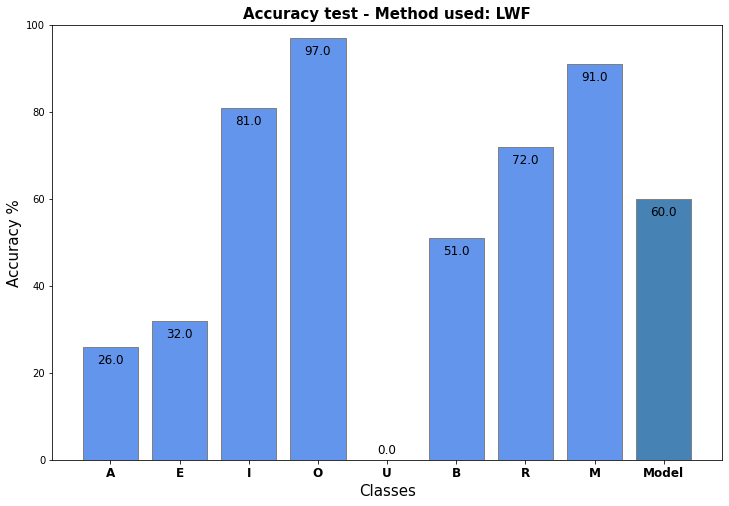

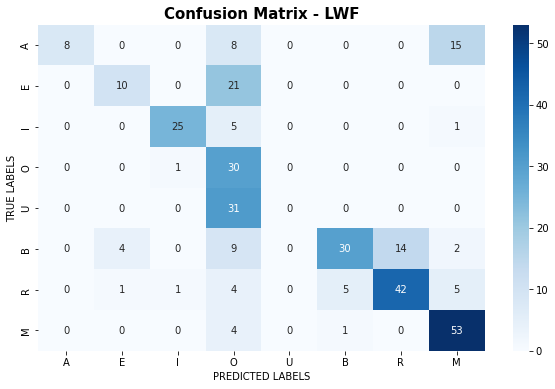

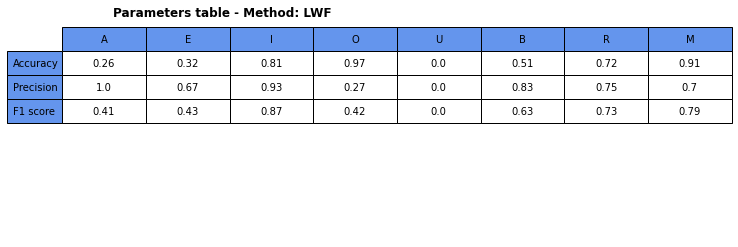

In [38]:
if(LWF==1):
    myTest.test_OLlayer(Model_LWF_1, OL_testing_data)
    myBar.plot_barChart(Model_LWF_1)
    myMatrix.plot_confMatrix(Model_LWF_1)
    myTable.table_params(Model_LWF_1)

### LWF + mini batch

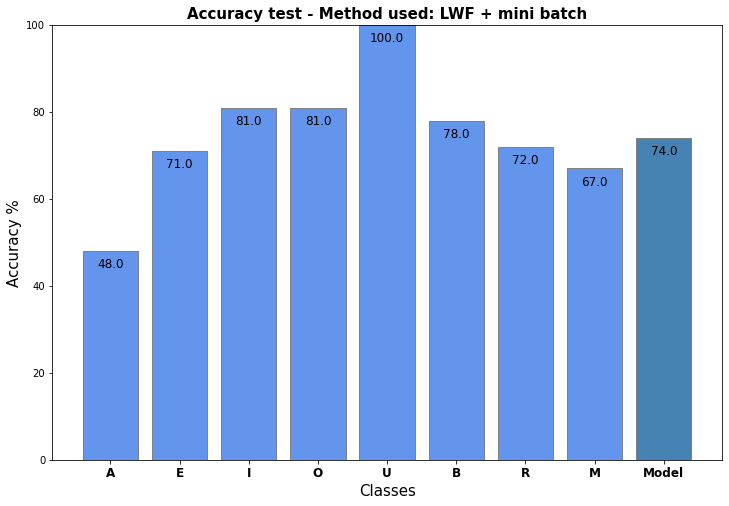

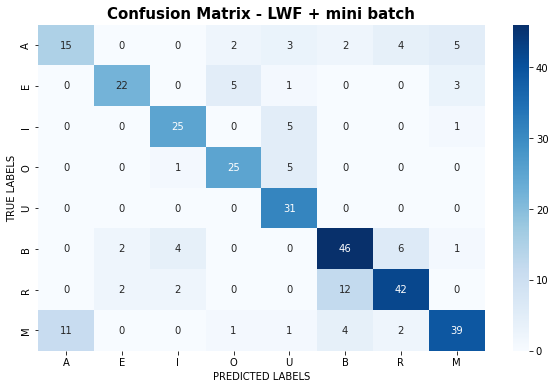

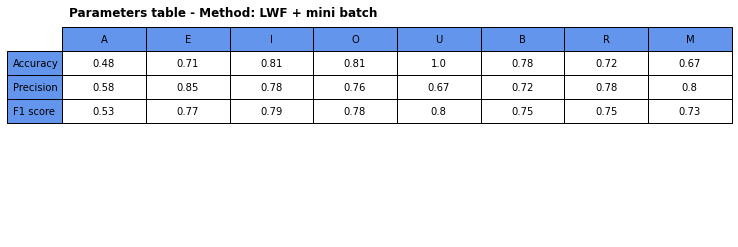

In [39]:
if(LWF_mini==1):
    myTest.test_OLlayer(Model_LWF_2, OL_testing_data)
    myBar.plot_barChart(Model_LWF_2)
    myMatrix.plot_confMatrix(Model_LWF_2)
    myTable.table_params(Model_LWF_2)

### OL v2

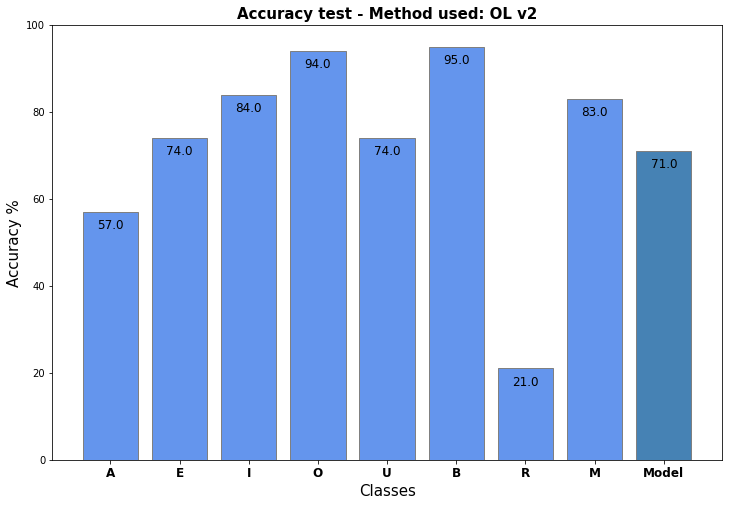

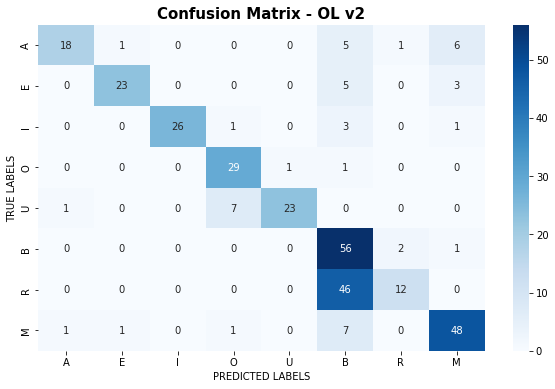

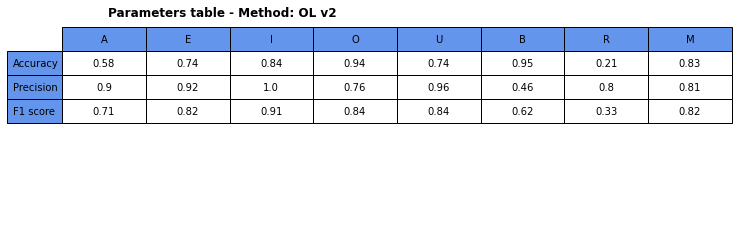

In [46]:
if(OL_v2==1):
    myTest.test_OLlayer(Model_OL_v2, OL_testing_data)
    myBar.plot_barChart(Model_OL_v2)
    myMatrix.plot_confMatrix(Model_OL_v2)
    myTable.table_params(Model_OL_v2)

### OL v2 + mini batch

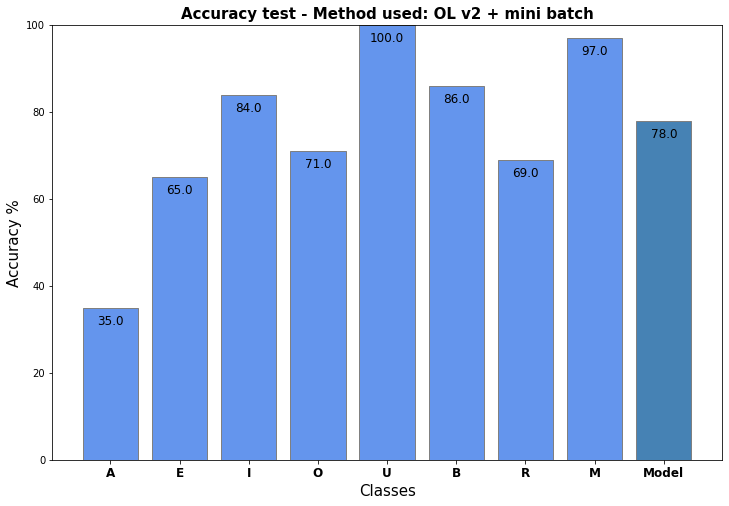

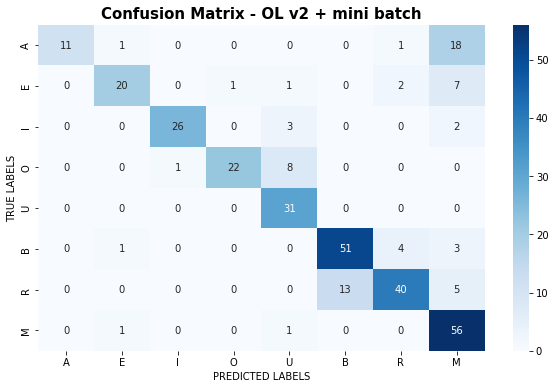

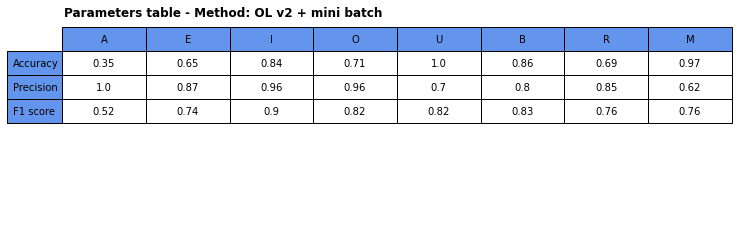

In [41]:
if(OL_v2_mini==1):
    myTest.test_OLlayer(Model_OL_v2_miniBatch, OL_testing_data)
    myBar.plot_barChart(Model_OL_v2_miniBatch)
    myMatrix.plot_confMatrix(Model_OL_v2_miniBatch)
    myTable.table_params(Model_OL_v2_miniBatch)

### CWR

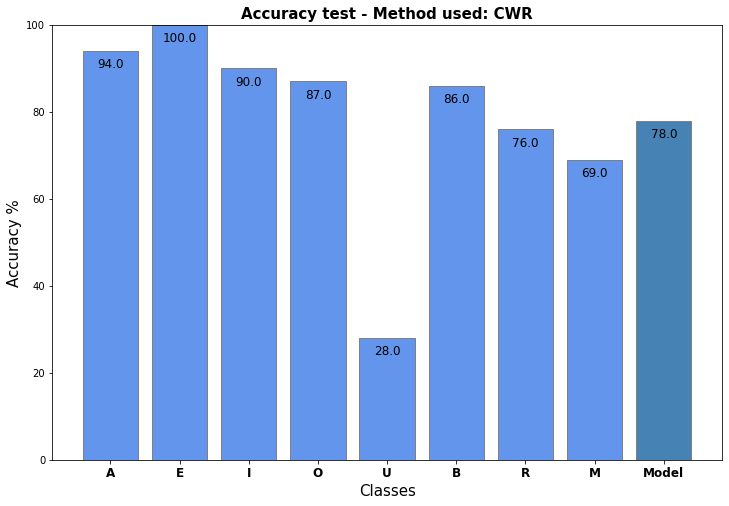

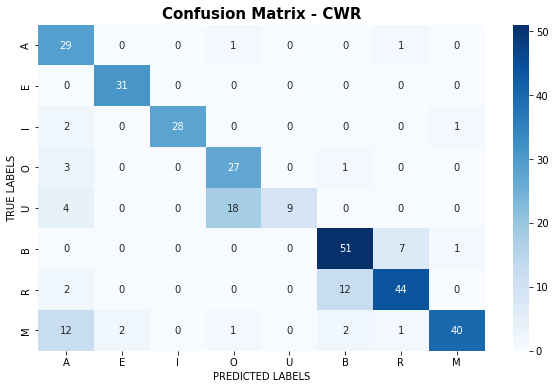

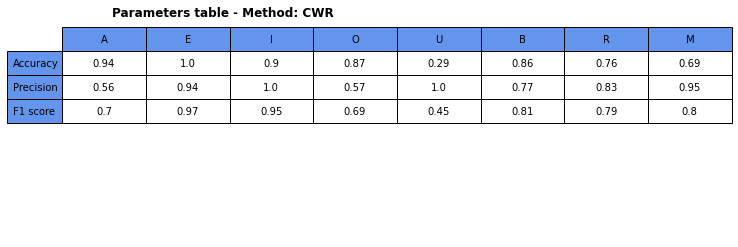

In [42]:
if(CWR==1):
    myTest.test_OLlayer(Model_CWR, OL_testing_data)
    myBar.plot_barChart(Model_CWR)
    myMatrix.plot_confMatrix(Model_CWR)
    myTable.table_params(Model_CWR)

## All bar plots together

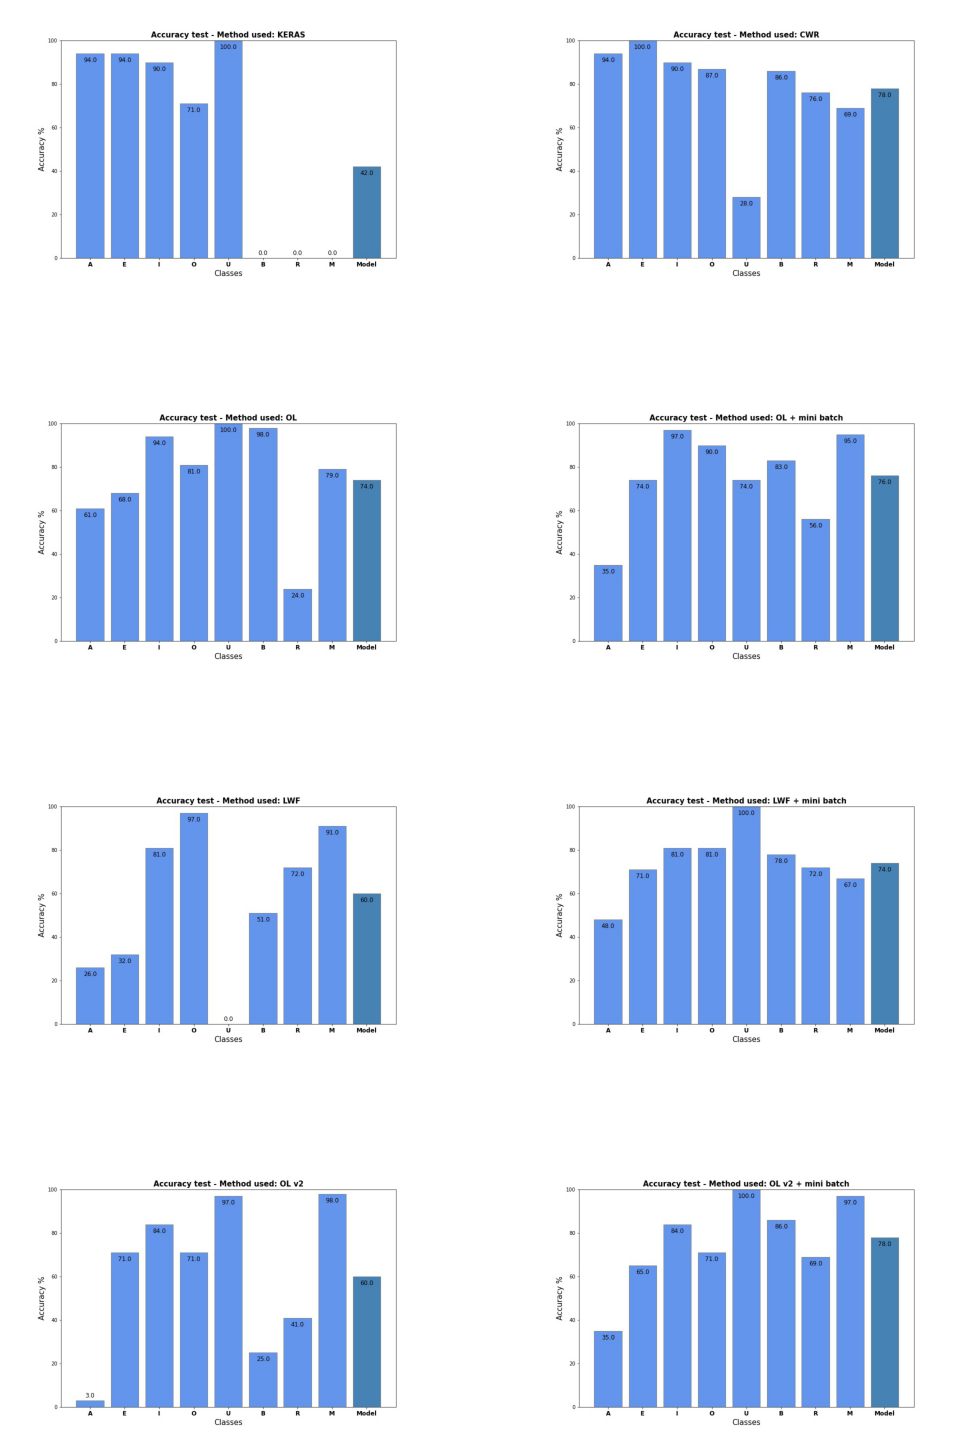

In [43]:
myBar.plot_barChart_All()

The following plot is a recap of all the methods trained. Note that it will be displayed only if all the training have been performed in this runtime. 
The table contains some additiona information and not only the accuracy.

In [ ]:
if(KERAS and OL_vowels and OL and OL_mini and LWF and LWF_mini and OL_v2 and OL_v2_mini and CWR):
    
    myTable.table_simulationResult(Model_KERAS, Model_OL_vowels, Model_OL_all_mixed, Model_OL_mini, 
               Model_LWF_1, Model_LWF_2, Model_OL_v2, Model_OL_v2_miniBatch, Model_CWR)  

# GENERAL PLOTS

The block below is used for storing the result of the simulation formermed in this runtime. This is used for another plotting function that will display the average accuracy of each method across multiple runtimes.

In [ ]:
# Write down in txt files all the results across 10 or so simulations          
WRITE_SIMU_RES = 0
                
if(WRITE_SIMU_RES==1):
    myWrite.save_simulationResult('Keras',     Model_KERAS)
    myWrite.save_simulationResult('OL_vowels', Model_OL_vowels)
    myWrite.save_simulationResult('OL',        Model_OL_all_mixed)
    myWrite.save_simulationResult('OL_mini',   Model_OL_mini)
    myWrite.save_simulationResult('LWF',       Model_LWF_1)
    myWrite.save_simulationResult('LWF_mini',  Model_LWF_2)
    myWrite.save_simulationResult('OL_v2',     Model_OL_v2)
    myWrite.save_simulationResult('OL_v2_min', Model_OL_v2_miniBatch)
    myWrite.save_simulationResult('CWR',       Model_CWR)

The block below plots some pie charts that shows how the dataset are composed.

In [ ]:
myBar.plot_barChart_SimuRes(1)


ENABLE_PLOTS = 0
if(ENABLE_PLOTS==1):
    
    
    vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_TF')
    TF_data_train, _, TF_data_test, _ = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)


    # Plot of the pie chart of the dataset TF e OL
    dataset_shapes = np.zeros([10])
    dataset_shapes[0] = TF_data_train.shape[0]
    dataset_shapes[1] = TF_data_test.shape[0]
    dataset_shapes[2] = OL_data_train_vow.shape[0]
    dataset_shapes[3] = OL_data_test_vow.shape[0]
    dataset_shapes[4] = B_train_data.shape[0]
    dataset_shapes[5] = B_test_data.shape[0]
    dataset_shapes[6] = R_train_data.shape[0]
    dataset_shapes[7] = R_test_data.shape[0]
    dataset_shapes[8] = M_train_data.shape[0]
    dataset_shapes[9] = M_test_data.shape[0]
    myPie.plot_pieChart_datasetAll(dataset_shapes)

    
    dataset_shapes = np.zeros([8])
    dataset_shapes[0] = OL_data_train_vow.shape[0]
    dataset_shapes[1] = OL_data_test_vow.shape[0]
    dataset_shapes[2] = B_train_data.shape[0]
    dataset_shapes[3] = B_test_data.shape[0]
    dataset_shapes[4] = R_train_data.shape[0]
    dataset_shapes[5] = R_test_data.shape[0]
    dataset_shapes[6] = M_train_data.shape[0]
    dataset_shapes[7] = M_test_data.shape[0]
    # Plot of the pie chart of the dataset OL
    myPie.plot_pieChart_DatasetOL(dataset_shapes)

    # Plot of the pie chart of the dataset TF
    myPie.plot_pieChart_DatasetTF(TF_data_train.shape[0],TF_data_test.shape[0])

In [49]:
print(Model_OL_v2.W[0,:10])
print(Model_KERAS.W[0,:10])

[-0.02980113 -0.14945661  0.01045771  0.17855997  0.12411576  0.03914037
 -0.19789355 -0.04363767]
[-0.02980113 -0.1494566   0.01045771  0.17855997  0.11365923]


In [ ]:
prova[0] = 
prova[1] = 
prova[2] = 
prova[3] = 
prova[4] = 
prova[5] = 
prova[6] = 
prova[7] = 

In [24]:
prova = np.zeros([8])

prova[0] = -125.585693
prova[1] = -504.634827
prova[2] = -19.7900848
prova[3] = 227.559601
prova[4] = 485.680267
prova[5] = -626.295349
prova[6] = -1977.03833
prova[7] = -729.068054

sft = my_Softmax(prova)
gigione = ['A','E','I','O','U','B','M','R']
print(sft)
print(gigione[np.argmax(sft)])

[1.00000000e+000 4.65493056e-215 1.16880087e-068 0.00000000e+000
 1.23363358e-136 0.00000000e+000 0.00000000e+000 0.00000000e+000]
A


In [42]:
i_tmp = 0
for i in range(0, data_all.shape[0]):
    if(data_all[i,0] == 603 and data_all[i,1] == 611):
        print(i)
        print(data_all[i,:10])
        i_tmp = i

707
[603. 611. 624. 636. 646. 654. 653. 636. 615. 596.]


In [43]:
tmp1 = Model_KERAS.ML_frozen.predict(data_all[i_tmp,:].reshape(1,data_all.shape[1]))
print(f'after frozen inference {tmp1[0,:10]}')
tmp2 = np.array(np.matmul(tmp1, Model_KERAS.W) + Model_KERAS.b)
print(f'after OL      {tmp2}')
tmp3 = my_Softmax(tmp2) 
print(f'after softmax { tmp3}')
tmp2 = Model_KERAS.predict(tmp1[0,:])   


after frozen inference [714.4855   860.3688     0.         0.         0.         0.
   0.         0.       545.8989   107.830376]
after OL      [[  54.06691 -705.465   -381.43732  147.96667 -240.8977 ]]
after softmax [1.65901458e-041 0.00000000e+000 1.20995079e-230 1.00000000e+000
 1.31324455e-169]


In [34]:
Model_KERAS.W[113,0]

-0.06310341